In [2]:
%matplotlib inline
import pylab
import numpy as np
import nengo
import nengo.spa as spa


The goal here is to make a model where you put something into working memory, then leave it there for a while, and then clear the working memory.  When people do this in real brains, they get this sort of effect

<img src=http://jn.physiology.org/content/jn/91/3/1424/F12.medium.gif/>

(Source: https://jn.physiology.org/content/91/3/1424 )

Let's try to model this as a high-dimensional integrator, an input, and some inhibition to shut it off at the end.

In [3]:
dimensions = 10
input_scale = 1
n_neurons_per_dim = 50
intercept_low = -0.5
intercept_high = 1.0
tau_input = 0.01
tau_recurrent = 0.1
tau_reset = 0.2
max_rate_high = 200
max_rate_low = 150
sensory_delay = 0.05
reset_scale = 0.3

model = nengo.Network()
with model:
    vocab = spa.Vocabulary(dimensions)
    value = vocab.parse('A').v
    
    def stim(t):
        if 0.5 < t - sensory_delay < 0.75:
            return value
        else:
            return [0]*dimensions
    stim = nengo.Node(stim)
    
    a = nengo.Ensemble(n_neurons=n_neurons_per_dim * dimensions,
                       dimensions=dimensions,
                       max_rates=nengo.dists.Uniform(max_rate_low, max_rate_high),
                       intercepts=nengo.dists.Uniform(intercept_low, intercept_high))
    
    b = nengo.Ensemble(n_neurons=n_neurons_per_dim * dimensions,
                       dimensions=dimensions,
                       max_rates=nengo.dists.Uniform(max_rate_low, max_rate_high),
                       intercepts=nengo.dists.Uniform(intercept_low, intercept_high))
    
    nengo.Connection(stim, a, synapse=None)
    nengo.Connection(a, b, synapse=tau_input, transform=input_scale)
    nengo.Connection(b, b, synapse=tau_recurrent)
    
    def reset(t):
        if t - sensory_delay > 1.75:
            return 1
        else:
            return 0
    reset_stim = nengo.Node(reset)
    reset_value = vocab.parse('B').v
    reset_value.shape = dimensions, 1
    nengo.Connection(reset_stim, b.neurons, transform=np.ones((b.n_neurons, 1))*-reset_scale, synapse=tau_reset)
    #nengo.Connection(reset_stim, b, transform=reset_value*reset_scale, synapse=tau_reset)
    
    p_value = nengo.Probe(b, synapse=0.01)
    p_neurons = nengo.Probe(b.neurons)

In [4]:
sim = nengo.Simulator(model)
sim.run(2.5)

Simulation finished in 0:00:02.                                                 


Here is the plot of the average firing rate across all the neurons

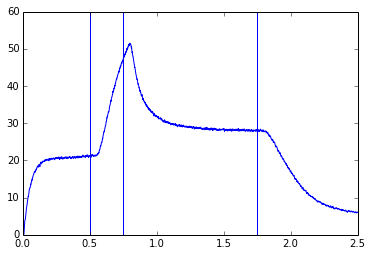

In [5]:
rates = sim.data[p_neurons]
ratesf = nengo.synapses.Lowpass(0.05).filt(rates)

pylab.plot(sim.trange(), np.mean(ratesf, axis=1))
pylab.axvline(0.5)
pylab.axvline(0.75)
pylab.axvline(1.75)
pylab.show()

But that's across all the neurons.  In the empirical data we're comparing to, it looks like they only selected neurons that are preferentially active for that stimulus.  This corresponds to the dot product between the encoder and the actual value being greater than zero.

However, the threshold probably shouldn't be exactly zero, as that would include a whole bunch of neurons that only just barely are preferentially active for the stimulus, and which probably wouldn't even be statistically determined to be preferentially active given the recording time.  So we probably need to do some sort of higher threshold.  But I don't know what it should be.

N= 249


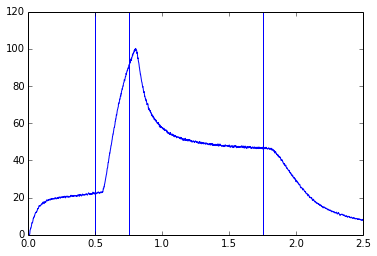

In [6]:
encs = sim.data[b].encoders
similarity = np.dot(encs, value)
items = np.where(similarity>0.0)   # TODO: What is this threshold in the real data?
print 'N= %d' % len(items[0])
pylab.plot(sim.trange(), np.mean(ratesf[:,items[0]], axis=1))
pylab.axvline(0.5)
pylab.axvline(0.75)
pylab.axvline(1.75)
pylab.show()

That's not a perfect match, but pretty close!

It'd be great to try to
* use hyperopt to try to fit the empirical data better
* do parameter exploration seeing how the different parameters affect the shape of the curve
